<a href="https://colab.research.google.com/github/jincy-p-janardhanan/Text-Clustering/blob/main/Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

In [ ]:
! pip install contractions
! pip install autocorrect
! pip install pattern

In [2]:
import requests
import nltk
import contractions
import string
import autocorrect
import re
from gensim.utils import lemmatize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import multiprocessing
import numpy as np

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

In [4]:
seed = 10

## Download dataset

In [5]:
def downloadfile(url, path):
  r = requests.get(url, stream=True)
  with open(path, "wb") as f:
    for block in r.iter_content(chunk_size=1024):
      if block:
        f.write(block)

In [6]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00314/%5bUCI%5d%20AAAI-13%20Accepted%20Papers%20-%20Papers.csv'
loc = '/content/'
filename = 'AAAI-accepted-papers-2013.csv'
path = loc+filename
downloadfile(url, path)

## Load Dataset

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv(path)
df.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,The cascade auction – a mechanism for deterrin...,Mediators\nAuctions\nCollusion\nAd Exchanges,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We introduce a sealed bid auction of a single ...
1,Basis Adaptation for Sparse Nonlinear Reinforc...,Reinforcement learning\nSparsity\nMirror desce...,Dimension Reduction/Feature Selection\nOnline ...,Machine Learning\nReasoning under Uncertainty,This paper presents a new approach to basis ad...
2,Optimal Coalition Structures in Cooperative Gr...,Cooperative Game Theory\nCoalition Structure G...,Coordination and Collaboration\nGame Theory,Multiagent Systems,Representation languages for coalitional game...
3,External Memory Best-First Search for Multiple...,External-Memory Search\nParallel Search\nMulti...,Heuristic Search\nEvaluation and Analysis (Sea...,Heuristic Search and Optimization,Multiple sequence alignment (MSA) is a central...
4,Posted Prices Exchange for Display Advertising...,Display Advertising\nDynamic Pricing\nMarket E...,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We propose a new market design for display adv...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  150 non-null    object
 1   Keywords               150 non-null    object
 2   Topics                 150 non-null    object
 3   High-Level Keyword(s)  150 non-null    object
 4   Abstract               150 non-null    object
dtypes: object(5)
memory usage: 6.0+ KB


# Text Preprocessing

Null value check

In [10]:
missing_values = df.isna().sum()
print(missing_values[missing_values>0])

Series([], dtype: int64)


Apply various text transformations (on a copy of the dataframe).

In [11]:
df2 = df.copy(deep=True)

# convert to lower case
df2 = df2.apply(lambda x: x.str.lower())

# fix contractions (E.g. it's => it is, I'm => I am, etc.)
df2 = df2.apply(lambda x:[contractions.fix(i) for i in x])

# To make keywords to arrays, first replace [' or ', ' and ', '\n' , '(', ')', '/'] with ' \n '
keywordcols = ['Keywords', 'Topics', 'High-Level Keyword(s)']
df2[keywordcols] = df2[keywordcols].apply(lambda x:[re.sub('( or | and |\\n|\(|\)|\/)', ' \n ', i) for i in x])

# Replace special characters (preserving space and \n) in keyowrd cols
df2[keywordcols] = df2[keywordcols].apply(lambda x: [re.sub('[^a-z0-9 \n]', ' ', i) for i in x])

# Replace special characters (preserving only space) in nonkey cols
nonkeycols = list(set(df2.columns) - set(keywordcols))
df2[nonkeycols] = df2[nonkeycols].apply(lambda x: [re.sub('[^a-z0-9]', ' ', i) for i in x])

# correct any misspelled words before splitting keywords
corrector = autocorrect.Speller()
df2 = df2.apply(lambda x: [corrector(i) for i in x])
df2.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,the cascade auction a mechanism for determin...,mediators \n auctions \n collusion \n ad excha...,auctions \n market based systems \n e commerce...,multiagent systems,we introduce a sealed bid auction of a single ...
1,basis adaptation for sparse nonlinear reinforc...,reinforcement learning \n varsity \n mirror de...,dimension reduction \n feature selection \n on...,machine learning \n reasoning under uncertainty,this paper presents a new approach to basis ad...
2,optimal coalition structures in cooperative gr...,cooperative game theory \n coalition structure...,coordination \n collaboration \n game theory,multiagent systems,representation languages for coalition games ...
3,external memory best first search for multiple...,external memory search \n parallel search \n m...,heuristic search \n evaluation \n analysis \n...,heuristic search \n optimization,multiple sequence alignment msa is a central...
4,posted prices exchange for display advertising...,display advertising \n dynamic pricing \n mark...,auctions \n market based systems \n e commerce...,multiagent systems,we propose a new market design for display adv...


In [12]:
# remove stop words and tokenize nonkey columns
df2[nonkeycols] = df2[nonkeycols].apply(
    lambda x: [[ w for w in i.split() 
    if w not in nltk.corpus.stopwords.words('english')] 
    for i in x])

# remove stop words and tokenize key columns (split on '\n')
df2[keywordcols] = df2[keywordcols].apply(
    lambda x: [[ w.strip() for w in i.split('\n') 
    if ((not w.isspace()) and (w not in nltk.corpus.stopwords.words('english')))] 
    for i in x])

In [13]:
# create a list of all keywords, with spaces; and another list of all keywords, without spaces (replaced by '_')
keywordset = set()
keywordset_joined = set()
df2[keywordcols].apply(
    lambda x: [ 
               (keywordset.add(j), keywordset_joined.add('_'.join(j.split()))) 
               for i in x for j in i])

keywordset = list(keywordset)
keywordset_joined = list(keywordset_joined)
keysetlen = len(keywordset)
print(keysetlen)

633


In [14]:
# print(keywordset_joined)

In [15]:
# replace spaces in keywords with '_' to get joined keywords
df2[keywordcols] = df2[keywordcols].apply(
    lambda x:[['_'.join(j.split()) for j in i] for i in x])

In [16]:
def replaceKeywords(text):
  for i in range(keysetlen):
    if keywordset[i] in text:
      text = text.replace(keywordset[i], keywordset_joined[i])
  return text

In [17]:
# replace any occurance of keywords in nonkey cols with the joined keyword
df2[nonkeycols] = df2[nonkeycols].apply(lambda x: [[replaceKeywords(j) for j in i] for i in x])

Not sure of why this happens, but the `lemmatize()` function works only after a few retries.

In [18]:
# Lemmatize tokens in nonkey cols
for attempt in range(1, 11):
  try:
    print(f'Lemmatize attempt: {attempt}')
    df2[nonkeycols] = df2[nonkeycols].apply(lambda x: [ 
                  [ (l.decode('utf-8')).split('/', 1)[0]
                    for w in wordlist for l in lemmatize(w)]
                  for wordlist in x])
    print(f'Attempt {attempt} success!')
    break
  except:
    pass

Lemmatize attempt: 1
Lemmatize attempt: 2
Lemmatize attempt: 3
Lemmatize attempt: 4
Attempt 4 success!


In [19]:
df2.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,"[cascade, auction, mechanism, determine]","[mediators, auctions, collusion, ad_exchanges]","[auctions, market_based_systems, e_commerce, g...",[multiagent_systems],"[introduce, seal, bid, auction, single, item, ..."
1,"[basis, adaptation, sparse, nonlinear, reinfor...","[reinforcement_learning, varsity, mirror_desce...","[dimension_reduction, feature_selection, onlin...","[machine_learning, reasoning_under_uncertainty]","[paper, present, new, approach, basis, adaptat..."
2,"[optimal, coalition, structure, cooperative, g...","[cooperative_game_theory, coalition_structure_...","[coordination, collaboration, game_theory]",[multiagent_systems],"[representation, language, coalition, lattice_..."
3,"[external, memory, best, first, deep_learn, mu...","[external_memory_search, parallel_search, mult...","[heuristic_search, evaluation, analysis, searc...","[heuristic_search, optimization]","[multiple, sequence, alignment, msa, central, ..."
4,"[post, price, exchange, display, advertising, ...","[display_advertising, dynamic_pricing, market_...","[auctions, market_based_systems, e_commerce, m...",[multiagent_systems],"[propose, new, market, design, display, advert..."


In [20]:
df.head()

,Title,Keywords,Topics,High-Level Keyword(s),Abstract
0,The cascade auction – a mechanism for deterrin...,Mediators\nAuctions\nCollusion\nAd Exchanges,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We introduce a sealed bid auction of a single ...
1,Basis Adaptation for Sparse Nonlinear Reinforc...,Reinforcement learning\nSparsity\nMirror desce...,Dimension Reduction/Feature Selection\nOnline ...,Machine Learning\nReasoning under Uncertainty,This paper presents a new approach to basis ad...
2,Optimal Coalition Structures in Cooperative Gr...,Cooperative Game Theory\nCoalition Structure G...,Coordination and Collaboration\nGame Theory,Multiagent Systems,Representation languages for coalitional game...
3,External Memory Best-First Search for Multiple...,External-Memory Search\nParallel Search\nMulti...,Heuristic Search\nEvaluation and Analysis (Sea...,Heuristic Search and Optimization,Multiple sequence alignment (MSA) is a central...
4,Posted Prices Exchange for Display Advertising...,Display Advertising\nDynamic Pricing\nMarket E...,Auctions and Market-Based Systems\nE-Commerce\...,Multiagent Systems,We propose a new market design for display adv...


In [21]:
df = df2.copy(deep=True)

# Visualization

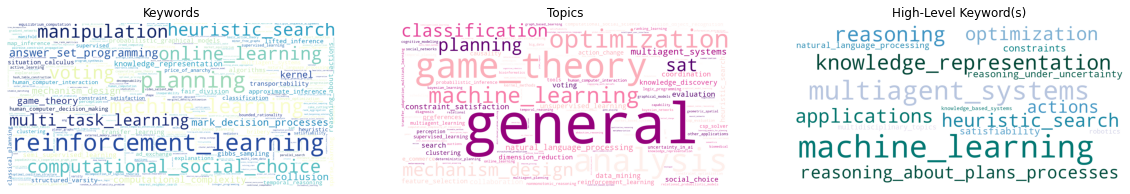

In [22]:
colormaps = ['YlGnBu', 'RdPu', 'PuBuGn']
plt.rcParams['figure.figsize'] = (20, 11)
for i in range(len(keywordcols)):
  wordcloud = WordCloud(collocations = False, width=1600, height=800, background_color='white', 
                        max_words=300, colormap=colormaps[i], random_state=seed
                        ).generate(' '.join([j for i in df[keywordcols[i]] for j in i]))
  
  plt.subplot(1, 3, i+1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(keywordcols[i])
plt.show()

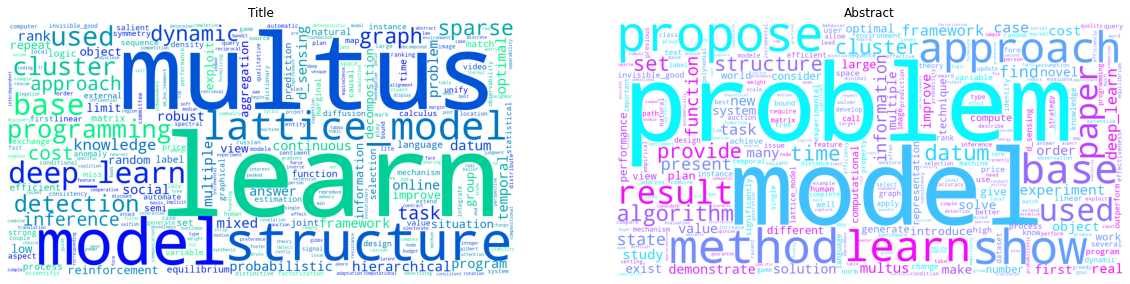

In [23]:
colormaps = ['winter', 'cool']
plt.rcParams['figure.figsize'] = (20, 11)
for i in range(len(nonkeycols)):
  wordcloud = WordCloud(collocations = False, width=1600, height=800, background_color='white', 
                        max_words=300, colormap=colormaps[i], random_state=seed
                        ).generate(' '.join([j for i in df[nonkeycols[i]] for j in i]))
  
  plt.subplot(1, 2, i+1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(nonkeycols[i])
plt.show()

# Word Embeddings

In [24]:
# import sklearn
# import numpy as np
# vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features = 5000)
# df['data'] = df.apply(lambda row: (' '.join(' '.join(i) for i in row.values)), axis=1)
# embedding = vectorizer.fit_transform(df['data'])
# embedding = sklearn.preprocessing.normalize(embedding)
# embedding = embedding.toarray()
# vocab_list = vectorizer.get_feature_names_out()
# embed_df = pd.DataFrame(embedding, columns=vocab_list).head()
# embed_df.describe()

In [25]:
vec_size = 300

In [26]:
df['datatokens'] = df.apply(lambda row: ' '.join(' '.join(i) for i in row.values).split(), axis=1)
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=4, window=4, size=vec_size, sg = 1, workers=cores-1, seed=seed)

w2v_model.build_vocab(df['datatokens'], progress_per=10000)
w2v_model.train(df['datatokens'], total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)

(1077971, 1499900)

In [27]:
w2v_model.wv.most_similar('machine_learning')

[('feature_selection', 0.6064468622207642),
 ('dimension_reduction', 0.5686918497085571),
 ('kernel_methods', 0.5627636909484863),
 ('transfer_adaptation_multitask_learning', 0.5326130390167236),
 ('classification', 0.5303205847740173),
 ('ranking_learning', 0.5245637893676758),
 ('structured_prediction', 0.5132051706314087),
 ('supervised_learning', 0.511332631111145),
 ('knowledge_discovery', 0.5108699798583984),
 ('unsupervised_learning', 0.5024862885475159)]

In [28]:
w2v_model.wv.most_similar('learn')

[('active_learning', 0.3925022482872009),
 ('lifelong', 0.3735233545303345),
 ('multi_task_learning', 0.3495635986328125),
 ('active', 0.34303808212280273),
 ('transfer_adaptation_multitask_learning', 0.34125858545303345),
 ('begin', 0.3328150510787964),
 ('retrieval', 0.32430216670036316),
 ('reinforcement', 0.31735989451408386),
 ('predictive', 0.3140637278556824),
 ('feature_selection', 0.31288665533065796)]

# Vectorize Documents

In [29]:
avg_feature_vectors = []

In [30]:
zeros = np.zeros((vec_size, 1))
zeros.shape

(300, 1)

In [31]:
documents = df2.to_records(index=False)

In [32]:
vectorized_df = []
for doc in documents:
  row_vector = []
  for col in doc:
    col_vector = []
    for token in col:
      if token in w2v_model.wv:
        col_vector.append(w2v_model.wv[token].reshape((vec_size, 1)))
      else:
        col_vector.append(zeros)
    row_vector.append(np.mean(np.asarray(col_vector), axis=0))
  vectorized_df.append(np.asarray(row_vector))
vectorized_df = np.squeeze(np.asarray(vectorized_df)) # To remove axes with 1 dimension
vectorized_df.shape

(150, 5, 300)

# K-Means Clustering

In [33]:
# NUM_CLUSTERS=10
# kclusterer = nltk.cluster.KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
# assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

In [34]:
# print(len(assigned_clusters))